In [166]:
from pathlib import Path
from pprint import pprint
import sys

import lief
from lief import PE
import numpy as np
import pandas as pd
import pefile

In [2]:
path = "../outputs/5/files/0003f09b129fac317bdf19e32dca9e189045d89c23eeeb9868861ac5f8a3e211.exe"

# Parse and Manipulate Formats

In [3]:
binary = lief.parse(path)

Unable to find the section associated with CERTIFICATE_TABLE


In [4]:
print(binary.dos_header)
print("-" * 32)
print(binary.header)
print("-" * 32)
print(binary.optional_header)

Magic:                        5a4d
Used Bytes In The LastPage:   90
File Size In Pages:           3
Number Of Relocation:         0
Header Size In Paragraphs:    4
Minimum Extra Paragraphs:     0
Maximum Extra Paragraphs:     ffff
Initial Relative SS:          0
Initial SP:                   b8
Checksum:                     0
Initial IP:                   0
Initial Relative CS:          0
Address Of Relocation Table:  40
Overlay Number:               0
OEM id:                       0
OEM info:                     0
Address Of New Exe Header:    c8

--------------------------------
Signature:                    50 45 0 0 
Machine:                      UNKNOWN
Number Of Sections:           5
Pointer To Symbol Table:      0
Number Of Symbols:            0
Size Of Optional Header:      e0
Characteristics:              RELOCS_STRIPPED - EXECUTABLE_IMAGE - LINE_NUMS_STRIPPED - LOCAL_SYMS_STRIPPED - CHARA_32BIT_MACHINE
Time Date Stamp:              57956397

--------------------------------
M

In [5]:
print(binary.get_section(".text"))

.text     615d      1000      6200      400       0         6.47403   CNT_CODE - MEM_EXECUTE - MEM_READ


In [6]:
for func in binary.imported_functions:
  print(func)

SetCurrentDirectoryW - 0x8070
GetFileAttributesW - 0x8074
GetFullPathNameW - 0x8078
Sleep - 0x807c
GetTickCount - 0x8080
CreateFileW - 0x8084
GetFileSize - 0x8088
MoveFileW - 0x808c
SetFileAttributesW - 0x8090
GetModuleFileNameW - 0x8094
CopyFileW - 0x8098
ExitProcess - 0x809c
SetEnvironmentVar... - 0x80a0
GetWindowsDirectoryW - 0x80a4
GetTempPathW - 0x80a8
GetCommandLineW - 0x80ac
GetVersion - 0x80b0
SetErrorMode - 0x80b4
WaitForSingleObject - 0x80b8
GetCurrentProcess - 0x80bc
CompareFileTime - 0x80c0
GlobalUnlock - 0x80c4
GlobalLock - 0x80c8
CreateThread - 0x80cc
GetLastError - 0x80d0
CreateDirectoryW - 0x80d4
CreateProcessW - 0x80d8
RemoveDirectoryW - 0x80dc
lstrcmpiA - 0x80e0
GetTempFileNameW - 0x80e4
WriteFile - 0x80e8
lstrcpyA - 0x80ec
lstrcpyW - 0x80f0
MoveFileExW - 0x80f4
lstrcatW - 0x80f8
GetSystemDirectoryW - 0x80fc
GetProcAddress - 0x8100
GetModuleHandleA - 0x8104
GlobalFree - 0x8108
GlobalAlloc - 0x810c
GetShortPathNameW - 0x8110
SearchPathW - 0x8114
lstrcmpiW - 0x8118
SetF

In [7]:
for imported_library in binary.imports:
  print("Library name: " + imported_library.name)
  for func in imported_library.entries:
    if not func.is_ordinal:
      print(func.name)
    print(func.iat_address)

Library name: KERNEL32.dll
SetCurrentDirectoryW
32880
GetFileAttributesW
32884
GetFullPathNameW
32888
Sleep
32892
GetTickCount
32896
CreateFileW
32900
GetFileSize
32904
MoveFileW
32908
SetFileAttributesW
32912
GetModuleFileNameW
32916
CopyFileW
32920
ExitProcess
32924
SetEnvironmentVariableW
32928
GetWindowsDirectoryW
32932
GetTempPathW
32936
GetCommandLineW
32940
GetVersion
32944
SetErrorMode
32948
WaitForSingleObject
32952
GetCurrentProcess
32956
CompareFileTime
32960
GlobalUnlock
32964
GlobalLock
32968
CreateThread
32972
GetLastError
32976
CreateDirectoryW
32980
CreateProcessW
32984
RemoveDirectoryW
32988
lstrcmpiA
32992
GetTempFileNameW
32996
WriteFile
33000
lstrcpyA
33004
lstrcpyW
33008
MoveFileExW
33012
lstrcatW
33016
GetSystemDirectoryW
33020
GetProcAddress
33024
GetModuleHandleA
33028
GlobalFree
33032
GlobalAlloc
33036
GetShortPathNameW
33040
SearchPathW
33044
lstrcmpiW
33048
SetFileTime
33052
CloseHandle
33056
ExpandEnvironmentStringsW
33060
lstrcmpW
33064
GetDiskFreeSpaceW
33

In [8]:
builder = lief.PE.Builder(binary)
builder.build_imports(True)
builder.patch_imports(True)
builder.build()
builder.write("result.exe")

# Create a PE from Scratch

In [9]:
title   = "LIEF is awesome\0"
message = "Hello World\0"

data =  list(map(ord, title))
data += list(map(ord, message))

code = [
        0x6a, 0x00,                         # push 0x00 uType
        0x68, 0x00, 0x20, 0x40, 0x00,       # push VA(title)
        0x68, 0x10, 0x20, 0x40, 0x00,       # push VA(message)
        0x6a, 0x00,                         # push 0 hWnd
        0xFF, 0x15, 0x54, 0x30, 0x40, 0x00, # call MessageBoxA
        0x6A, 0x00,                         # push 0 uExitCode
        0xFF, 0x15, 0x4C, 0x30, 0x40, 0x00  # call ExitProcess
        ]

In [10]:
section_text                 = PE.Section(".text")
section_text.content         = code
section_text.virtual_address = 0x1000

section_data                 = PE.Section(".data")
section_data.content         = data
section_data.virtual_address = 0x2000

In [11]:
binary32 = PE.Binary("pe_from_scratch", PE.PE_TYPE.PE32)

In [12]:
section_text = binary32.add_section(section_text, PE.SECTION_TYPES.TEXT)
section_data = binary32.add_section(section_data, PE.SECTION_TYPES.DATA)
print(section_text)
print(section_data)

.text     1c        1000      200       400       0         0.362359  CNT_CODE - MEM_EXECUTE - MEM_READ
.data     1c        2000      200       600       0         0.487347  CNT_INITIALIZED_DATA - MEM_READ - MEM_WRITE


In [13]:
binary32.optional_header.addressof_entrypoint = section_text.virtual_address

kernel32 = binary32.add_library("kernel32.dll")
kernel32.add_entry("ExitProcess")

user32 = binary32.add_library("user32.dll")
user32.add_entry("MessageBoxA")

In [14]:
ExitProcess_addr = binary32.predict_function_rva("kernel32.dll", "ExitProcess")
MessageBoxA_addr = binary32.predict_function_rva("user32.dll", "MessageBoxA")
print("Address of 'ExitProcess': 0x{:06x} ".format(ExitProcess_addr))
print("Address of 'MessageBoxA': 0x{:06x} ".format(MessageBoxA_addr))

Address of 'ExitProcess': 0x00304c 
Address of 'MessageBoxA': 0x003054 


In [15]:
builder = PE.Builder(binary32)
builder.build_imports(True)
builder.build()
builder.write("pe_from_scratch.exe")

# PE Hooking

In [16]:
title = "LIEF is awesome\0"
data  =  list(map(ord, title))
code = [
        0x48, 0x83, 0xc4, 0x48,                                     # add rsp, 0x48         ; Stack unwind
        0x48, 0x31, 0xc9,                                           # xor rcx, rcx          ; hWnd
        0x48, 0x89, 0xd2,                                           # mov rdx, rdx          ; Message
        0x49, 0xb8, 0x00, 0x90, 0x00, 0x40, 0x01, 0x00, 0x00, 0x00, # mov r8,  0x0140009000 ; Title
        0x4d, 0x31, 0xc9,                                           # xor r9, r9            ; MB_OK
        0x48, 0xb8, 0xe4, 0xa3, 0x00, 0x40, 0x01, 0x00, 0x00, 0x00, # mov rax, 0x014000A3E4 ; MessageBoxA address
        0xff, 0x10,                                                 # call [rax]            ; MessageBoxA(hWnd, Message, Title, MB_OK)
        0x48, 0x31, 0xc9,                                           # xor rcx, rcx          ; exit value
        0x48, 0xb8, 0xd4, 0xa3, 0x00, 0x40, 0x01, 0x00, 0x00, 0x00, # mov rax, 0x014000A3d4 ; ExitProcess address
        0xff, 0x10,                                                 # call [rax]            ; ExitProcess(0)
        0xc3,                                                       # ret                   ; Never reached
        ]

In [17]:
# Create a '.text' section which will contain the hooking code
section_text                 = lief.PE.Section(".htext")
section_text.content         = code
section_text.virtual_address = 0x8000
section_text.characteristics = (lief.PE.SECTION_CHARACTERISTICS.CNT_CODE | lief.PE.SECTION_CHARACTERISTICS.MEM_READ | lief.PE.SECTION_CHARACTERISTICS.MEM_EXECUTE)
print(section_text)

.htext    0         8000      0         0         0         3.76004   CNT_CODE - MEM_EXECUTE - MEM_READ


In [18]:
# Create '.data' section for the string(s)
section_data                 = lief.PE.Section(".hdata")
section_data.content         = data
section_data.virtual_address = 0x9000
section_data.characteristics = (lief.PE.SECTION_CHARACTERISTICS.CNT_INITIALIZED_DATA | lief.PE.SECTION_CHARACTERISTICS.MEM_READ)
print(section_data)

.hdata    0         9000      0         0         0         3.625     CNT_INITIALIZED_DATA - MEM_READ


In [19]:
binary = lief.parse("PE64_x86-64_binary_HelloWorld.exe")
# Disable ASLR
binary.optional_header.dll_characteristics &= ~lief.PE.DLL_CHARACTERISTICS.DYNAMIC_BASE # bitwise not
# Disable NX protection
binary.optional_header.dll_characteristics &= ~lief.PE.DLL_CHARACTERISTICS.NX_COMPAT # bitwise not

In [20]:
# Add the sections
section_text = binary.add_section(section_text)
section_data = binary.add_section(section_data)

# Add the 'ExitProcess' function to kernel32
kernel32 = binary.get_import("KERNEL32.dll")
kernel32.add_entry("ExitProcess")

# Add the 'user32.dll' library
user32 = binary.add_library("user32.dll")

# Add the 'MessageBoxA' function
user32.add_entry("MessageBoxA")

In [21]:
ExitProcess_addr = binary.predict_function_rva("KERNEL32.dll", "ExitProcess")
MessageBoxA_addr = binary.predict_function_rva("user32.dll", "MessageBoxA")
print("Address of 'MessageBoxA': 0x{:06x} ".format(MessageBoxA_addr))
print("Address of 'ExitProcess': 0x{:06x} ".format(ExitProcess_addr))

Address of 'MessageBoxA': 0x00a3e4 
Address of 'ExitProcess': 0x00a3d4 


In [22]:
# Hook the '__acrt_iob_func' function with our code
binary.hook_function("__acrt_iob_func", binary.optional_header.imagebase + section_text.virtual_address)
# Invoke the builder
builder = lief.PE.Builder(binary)
# Configure it to rebuild and patch the imports
builder.build_imports(True).patch_imports(True)
# Build !
builder.build()
# Save the result
builder.write("lief_pe64_hooking.exe")

# PE Resources

In [23]:
filezilla = lief.parse("filezilla.exe")
if not filezilla.has_resources:
    print("'{}' has no resources. Abort!".format(filezilla.name), file=sys.stderr)
    sys.exit(1)
root = filezilla.resources

In [24]:
childs = list(root.childs)
print(childs)
ids = [e.id for e in childs]
print(ids)
names = [type(e) for e in childs]
print(names)
filtered = list(filter(lambda e : e.id == lief.PE.RESOURCE_TYPES.MANIFEST, root.childs))
print(filtered)
lief.PE.RESOURCE_TYPES.MANIFEST

[<lief.PE.ResourceDirectory object at 0x7f0c34494930>, <lief.PE.ResourceDirectory object at 0x7f0c34494d70>, <lief.PE.ResourceDirectory object at 0x7f0c344949f0>, <lief.PE.ResourceDirectory object at 0x7f0c34494cf0>, <lief.PE.ResourceDirectory object at 0x7f0c344948f0>, <lief.PE.ResourceDirectory object at 0x7f0c344d12f0>, <lief.PE.ResourceDirectory object at 0x7f0c344d1a30>, <lief.PE.ResourceDirectory object at 0x7f0c344d11b0>]
[1, 2, 3, 4, 12, 14, 16, 24]
[<class 'lief.PE.ResourceDirectory'>, <class 'lief.PE.ResourceDirectory'>, <class 'lief.PE.ResourceDirectory'>, <class 'lief.PE.ResourceDirectory'>, <class 'lief.PE.ResourceDirectory'>, <class 'lief.PE.ResourceDirectory'>, <class 'lief.PE.ResourceDirectory'>, <class 'lief.PE.ResourceDirectory'>]
[]


<RESOURCE_TYPES.MANIFEST: 24>

In [25]:
# First level => Type
manifest_node = next(filter(lambda e : e.id == lief.PE.RESOURCE_TYPES.MANIFEST, root.childs))
print(manifest_node)

StopIteration: 

In [ ]:
# Second level => ID
id_node = manifest_node.childs[0]
print(id_node)

In [ ]:
# Third level => Lang (Data node)
lang_node = id_node.childs[0]
print(lang_node)

In [ ]:
manifest = bytes(lang_node.content).decode("utf8")
print(manifest)

In [ ]:
manifest = manifest.replace("asInvoker", "requireAdministrator")
print(manifest)

In [ ]:
lang_node.content = list(manifest.encode("utf8"))

In [ ]:
# Rebuild
builder = lief.PE.Builder(filezilla)
builder.build_resources(True)
builder.build()
builder.write("filezilla_v2.exe")

# Identify Offsets

In [ ]:
import lief
path = "../outputs/5/files/0003f09b129fac317bdf19e32dca9e189045d89c23eeeb9868861ac5f8a3e211.exe"
binary = lief.parse(path)

In [ ]:
section = binary.get_section(".text")

In [ ]:
type(section)

In [ ]:
section.offset, section.size
section.offset + section.size

In [ ]:
sorted([s.offset for s in binary.sections])

In [ ]:
try:
    binary.get_section("jhbfds")
except Exception as e:
    print(type(e))
    raise e

# Parse returning None

In [ ]:
path = "/home/lk3591/Documents/datasets/Windows/processed/train/7e4c888acfca1c4068a76f1b61874554d7c3e4dc335f6d298ff8abbe.exe"
binary = lief.parse(path)

In [ ]:
print(binary)

# Modifying Malware to Make it Less Suspicious

In [10]:
import capstone as cs
import lief
path = "../outputs/5/files/0003f09b129fac317bdf19e32dca9e189045d89c23eeeb9868861ac5f8a3e211.exe"
binary = lief.parse(path)

Unable to find the section associated with CERTIFICATE_TABLE


In [11]:
text = binary.get_section(".text")
content = [hex(i) for i in text.content]

In [12]:
cs

## Weird

In [19]:
from pathlib import Path
import lief
lief.__version__

'0.12.2-2169578d'

In [26]:
path = "/home/lk3591/Documents/datasets/Sorel/processed/train/0008c1b3154f651e089c62c9b289911f808dd85992e3392db2f5d443e821b4a6"
path_analogue = Path(path).name + "analogue"

In [21]:
binary = lief.parse(path)
binary.virtual_size

Can't read the padding content of section '.text'
Data of section section '.rdata' is too large (0xfffdb828)
Data of section section '.data' is too large (0xfffd4828)


368640

In [22]:
sections = list(binary.sections)
c = lief.PE.SECTION_CHARACTERISTICS(32)
for s in sections:
    print(f"{s.name}: {s.offset} - {s.offset + s.size} {s.has_characteristic(c)}")

.text: 4096 - 221184 True
.rdata: 221184 - 249856 False
.data: 249856 - 278528 False


In [14]:
binary.get_section(".text").content = [0x0 for _ in range(221184 - 4096)]

In [15]:
builder = lief.PE.Builder(binary)
builder.build_imports(True)
builder.build()
builder.write(path + "analogue")

In [16]:
b = open(path, "rb").read()
len(b)

71720

In [27]:
binary_analogue = lief.parse(path_analogue)
sections = list(binary_analogue.sections)

In [28]:
sections = list(binary_analogue.sections)
c = lief.PE.SECTION_CHARACTERISTICS(32)
for s in sections:
    print(f"{s.name}: {s.offset} - {s.offset + s.size} {s.has_characteristic(c)}")

.text: 4096 - 221184 True
.rdata: 221184 - 249856 False
.data: 249856 - 278528 False


In [29]:
b2 = open(path_analogue, "rb").read()
len(b2)

278528

In [34]:
binary_analogue.get_section(".text").size

217088

In [38]:
c = binary_analogue.get_section(".text").content

In [39]:
len(list(c))

214174

## Malware's offsets larger than file length

In [70]:
import lief

In [71]:
path = "/home/lk3591/Documents/datasets/Sorel/processed/train/001856267679fb6001cd00f230043326e1b9fc210874dd4c839761d51f4e9a73"

In [72]:
# LIEF's backend engine prints some complaints, but it does this for a lot of files
binary = lief.parse(path)

Can't read the padding content of section '.text'
Can't read the padding content of section '.data'
Data of section section '.rsrc' is too large (0xffff48db)


In [73]:
# Some information about the various sections within the executable
for s in binary.sections:
    print(f"Name: {s.name}\tOffset (start):{s.offset}\tOffset (end):{s.offset + s.size}")

Name: .text	Offset (start):4096	Offset (end):69632
Name: .data	Offset (start):0	Offset (end):0
Name: .rsrc	Offset (start):69632	Offset (end):98304


In [74]:
# We can determine the number of bytes in the file by reading them
raw = open(path, "rb").read()
len(raw)

22747

In [75]:
# The file appears not to be gzipped
import gzip
try:
    with gzip.open(path, "rb") as f:
        print(f.read())
except gzip.BadGzipFile:
    print("Not a gzipped file.")

Not a gzipped file.


In [78]:
text_section = binary.get_section(".text")

In [81]:
text_content = list(text_section.content)

In [92]:
dos_header = binary.dos_header
header = binary.header

In [101]:
header.pointerto_symbol_table

0

# Identifying .text sections in Malware/Benign-ware

In [1]:
import pefile
from torch import Tensor
from tqdm import tqdm

from classifier import (
    confidence_scores,
    get_model,
    MALCONV_PATH,
    SOREL_TRAIN_PATH,
    WINDOWS_TRAIN_PATH,
    WINDOWS_TEST_PATH,
)
from executable_helper import read_binary

CONFIG
----------------------------------------------------------------------------------------
SEED=0
device=device(type='cpu')
torch.backends.cudnn.enabled=False


In [3]:
def print_pe_summary(pe: pefile.PE):
    for s in pe.sections:
        section = s.Name.decode("utf-8", errors="ignore")
        addr = s.Misc_PhysicalAddress
        size = s.SizeOfRawData
        v_addr = s.VirtualAddress
        v_size = s.Misc_VirtualSize
        print(f"{section=}\n\t{addr=}\n\t{size=}")#\n\t{v_addr=}\n\t{v_size=}")

def file_size(path):
    return len(open(path, 'rb').read())

def get_text_section(pe: pefile.PE):
    for s in pe.sections:
        if ".text" in s.Name.decode("utf-8", errors="ignore"):
            return s
    return None

model = get_model("gct")

In [8]:
# Strange malware with .text section larger than file length
path = SOREL_TRAIN_PATH / "001856267679fb6001cd00f230043326e1b9fc210874dd4c839761d51f4e9a73"
pe = pefile.PE(path)
ts = get_text_section(pe)
print(f"FileSize            {file_size(path)}  =  {hex(file_size(path))}")
print(f"PointerToRawData    {ts.PointerToRawData}   =  {hex(ts.PointerToRawData)}")
print(f"SizeOfRawData       {ts.SizeOfRawData}  =  {hex(ts.SizeOfRawData)}")

FileSize            22747  =  0x58db
PointerToRawData    4096   =  0x1000
SizeOfRawData       65536  =  0x10000


In [4]:
print(f"FileSize:{hex(file_size(path))}")
print(pe.dump_info())

FileSize:0x58db
----------Parsing Warnings----------

Byte 0x00 makes up 51.8398% of the file's contents. This may indicate truncation / malformation.

Error parsing section 0. SizeOfRawData is larger than file.

Error parsing section 2. SizeOfRawData is larger than file.

Error parsing section 2. PointerToRawData points beyond the end of the file.

Corrupt header "IMAGE_IMPORT_DESCRIPTOR" at file offset 65508. Exception: 'Data length less than expected header length.'

Corrupt header "IMAGE_RESOURCE_DIRECTORY" at file offset 69632. Exception: 'Data length less than expected header length.'

Invalid resources directory. Can't parse directory data at RVA: 0x14000

----------DOS_HEADER----------

[IMAGE_DOS_HEADER]
0x0        0x0   e_magic:                       0x5A4D    
0x2        0x2   e_cblp:                        0x90      
0x4        0x4   e_cp:                          0x3       
0x6        0x6   e_crlc:                        0x0       
0x8        0x8   e_cparhdr:              

In [5]:
X = Tensor(read_binary(path)).unsqueeze(0)
conf = confidence_scores(model, X).item()
conf

0.998144268989563

In [6]:
# Normal malware
path = SOREL_TRAIN_PATH / "00264f6c56cf21a8bd3202fccd7758221f363ca027c474d84901bb9f5e5f67dd"
pe = pefile.PE(path)
print(f"FileSize={file_size(path)}")
print(f"{ts.PointerToRawData=}")
print(f"{ts.SizeOfRawData=}")

FileSize=1102372
ts.PointerToRawData=4096
ts.SizeOfRawData=65536


In [7]:
print(f"FileSize:{hex(file_size(path))}")
print(pe.dump_info())

FileSize:0x10d224
----------Parsing Warnings----------

Error parsing section 1. SizeOfRawData is larger than file.

Error parsing section 2. SizeOfRawData is larger than file.

Error parsing section 2. PointerToRawData points beyond the end of the file.

Error parsing section 3. SizeOfRawData is larger than file.

Error parsing section 3. PointerToRawData points beyond the end of the file.

Error parsing section 4. SizeOfRawData is larger than file.

Error parsing section 4. PointerToRawData points beyond the end of the file.

Error parsing section 5. SizeOfRawData is larger than file.

Error parsing section 5. PointerToRawData points beyond the end of the file.

Error parsing section 6. SizeOfRawData is larger than file.

Error parsing section 6. PointerToRawData points beyond the end of the file.

Error parsing section 7. SizeOfRawData is larger than file.

Error parsing section 7. PointerToRawData points beyond the end of the file.

Too many errors parsing the import directory. Inv

In [8]:
X = Tensor(read_binary(path)).unsqueeze(0)
conf = confidence_scores(model, X).item()
conf

0.9983325600624084

In [9]:
# Benign-ware with a large .text section
path = WINDOWS_TRAIN_PATH / "09024e62ccab97df3b535e1d65025c54d2d8a684b9e6dcebba79786d.exe"
pe = pefile.PE(path)
print(f"FileSize={file_size(path)}")
print(f"{ts.PointerToRawData=}")
print(f"{ts.SizeOfRawData=}")

FileSize=4266712
ts.PointerToRawData=4096
ts.SizeOfRawData=65536


In [10]:
print(f"FileSize:{hex(file_size(path))}")
print(pe.dump_info())

FileSize:0x411ad8
----------DOS_HEADER----------

[IMAGE_DOS_HEADER]
0x0        0x0   e_magic:                       0x5A4D    
0x2        0x2   e_cblp:                        0x90      
0x4        0x4   e_cp:                          0x3       
0x6        0x6   e_crlc:                        0x0       
0x8        0x8   e_cparhdr:                     0x4       
0xA        0xA   e_minalloc:                    0x0       
0xC        0xC   e_maxalloc:                    0xFFFF    
0xE        0xE   e_ss:                          0x0       
0x10       0x10  e_sp:                          0xB8      
0x12       0x12  e_csum:                        0x0       
0x14       0x14  e_ip:                          0x0       
0x16       0x16  e_cs:                          0x0       
0x18       0x18  e_lfarlc:                      0x40      
0x1A       0x1A  e_ovno:                        0x0       
0x1C       0x1C  e_res:                         
0x24       0x24  e_oemid:                       0x0     

In [11]:
X = Tensor(read_binary(path)).unsqueeze(0)
conf = confidence_scores(model, X).item()
conf

0.0006344712455756962

In [12]:
# Benign-ware
path = WINDOWS_TRAIN_PATH / "f20a100e661a3179976ccf06ce4a773cbe8d19cd8f50f14e41c0a9e6.exe"
pe = pefile.PE(path)
print(f"FileSize={file_size(path)}")
print(f"{ts.PointerToRawData=}")
print(f"{ts.SizeOfRawData=}")

FileSize=116224
ts.PointerToRawData=4096
ts.SizeOfRawData=65536


In [13]:
print(f"FileSize:{hex(file_size(path))}")
print(pe.dump_info())

FileSize:0x1c600
----------Parsing Warnings----------

Byte 0xcc makes up 26.9075% of the file's contents. This may indicate truncation / malformation.

----------DOS_HEADER----------

[IMAGE_DOS_HEADER]
0x0        0x0   e_magic:                       0x5A4D    
0x2        0x2   e_cblp:                        0x90      
0x4        0x4   e_cp:                          0x3       
0x6        0x6   e_crlc:                        0x0       
0x8        0x8   e_cparhdr:                     0x4       
0xA        0xA   e_minalloc:                    0x0       
0xC        0xC   e_maxalloc:                    0xFFFF    
0xE        0xE   e_ss:                          0x0       
0x10       0x10  e_sp:                          0xB8      
0x12       0x12  e_csum:                        0x0       
0x14       0x14  e_ip:                          0x0       
0x16       0x16  e_cs:                          0x0       
0x18       0x18  e_lfarlc:                      0x40      
0x1A       0x1A  e_ovno:     

In [14]:
X = Tensor(read_binary(path)).unsqueeze(0)
conf = confidence_scores(model, X).item()
conf

3.3748142413969617e-06

In [21]:
data = []
for path in tqdm(list(WINDOWS_TEST_PATH.iterdir())):
    X = Tensor(read_binary(path)).unsqueeze(0)
    conf = confidence_scores(model, X).item()
    _, l, u = next(text_section_bounds(path, "pefile", "ignore"))
    data.append((path, l, u, conf))

  3%|▎         | 39/1464 [00:11<06:49,  3.48it/s]

Found 1 / 1 good files.


StopIteration: 

In [23]:
data[0:5]

[(PosixPath('/home/lk3591/Documents/datasets/Windows/processed/test/f6bb0b1f6a55cceb02598ba37f744d12b1b44064e1fd44c357c3303d.exe'),
  1024,
  39936,
  9.286905272576362e-11),
 (PosixPath('/home/lk3591/Documents/datasets/Windows/processed/test/d12a0fab485a1f045db0837fe337e9fd5b72c8aa37b399e145b90c39.exe'),
  1024,
  304640,
  3.468932118266821e-05),
 (PosixPath('/home/lk3591/Documents/datasets/Windows/processed/test/701f928760a612a1e929551ca12363394922f30c7f8181f4df5b0ec0.exe'),
  1024,
  2668032,
  1.5929343177845112e-08),
 (PosixPath('/home/lk3591/Documents/datasets/Windows/processed/test/509a8487983a3525b6045f701bb90d3346247584c2759bed1a78fbd5.exe'),
  4096,
  2568192,
  0.0002767131954897195),
 (PosixPath('/home/lk3591/Documents/datasets/Windows/processed/test/6e2b9d62a3d2c20439273751894a5f44dffe5eb8d00e39e45f1c56aa.exe'),
  1024,
  2668032,
  1.5929343177845112e-08)]

In [31]:
from pathlib import Path
from pprint import pprint

from classifier import WINDOWS_TEST_PATH, WINDOWS_TRAIN_PATH
from executable_helper import text_section_bounds

In [28]:
x = [e for e in text_section_bounds(WINDOWS_TEST_PATH.iterdir(), "pefile", errors="ignore")]
x.sort(key=lambda e: e[2] - e[1])

Found 1464 / 1464 good files.


In [29]:
BENIGN_FILES = [
    WINDOWS_TRAIN_PATH / f
    for f in [
        "701f928760a612a1e929551ca12363394922f30c7f8181f4df5b0ec0.exe",  # 0% malicious
        "f20a100e661a3179976ccf06ce4a773cbe8d19cd8f50f14e41c0a9e6.exe",  # 0% malicious
        "09024e62ccab97df3b535e1d65025c54d2d8a684b9e6dcebba79786d.exe",  # 99% malicious
    ]
] + [
    WINDOWS_TEST_PATH / f
    for f in [
        "05efe7acbe79a7f925c5bc763d11f9d5a1daa2055d297436d0325a1b.exe",
        "256838fe2f037b8865a49d0485c568923f561fea082aa5fa656d6b2d.exe",
        "efe6c4f2299bdc4b89ea935c05c8ebc740937cc7ee4a3948ba552a92.exe"
    ]
]

[(PosixPath('/home/lk3591/Documents/datasets/Windows/processed/test/2e11febcbf9f0559ba1f4a5a68bc6094c92dbe3670ce9e6cff6ebe95.exe'),
  512,
  3072),
 (PosixPath('/home/lk3591/Documents/datasets/Windows/processed/test/0704526e423c115e6874fe0451239b9b6a4c1326d3c2ceb2ea0585a6.exe'),
  512,
  3072),
 (PosixPath('/home/lk3591/Documents/datasets/Windows/processed/test/0a77cf634fbb81cc9cebfab1edcd4fd36a3ef1d7b5c9492dcb186bf2.exe'),
  512,
  3072),
 (PosixPath('/home/lk3591/Documents/datasets/Windows/processed/test/68c295635bb1912d9fdad50879238034b397b5f665eab9a015a625cf.exe'),
  512,
  3072),
 (PosixPath('/home/lk3591/Documents/datasets/Windows/processed/test/df83a06717c9a66c231d14dd4e65b65d84a23b7c2b3945ac2250a008.exe'),
  512,
  3072),
 (PosixPath('/home/lk3591/Documents/datasets/Windows/processed/test/6b447b4f0b8ce4f614921068225a1dd92bafed895e286541e6790174.exe'),
  512,
  3072),
 (PosixPath('/home/lk3591/Documents/datasets/Windows/processed/test/af8d7dadb64521fa6ad91051674d6e75990454887b0b

In [30]:
from modify_malware import BENIGN_FILES

ImportError: cannot import name 'CONFIDENCE_THRESHOLD' from 'classifier' (/home/lk3591/Documents/MalConv2/classifier.py)

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
df = pd.read_csv("/home/lk3591/Documents/MalConv2/output_model/two/cum_results.csv")
confs = df["ts_confs"].to_numpy()

In [39]:
c =

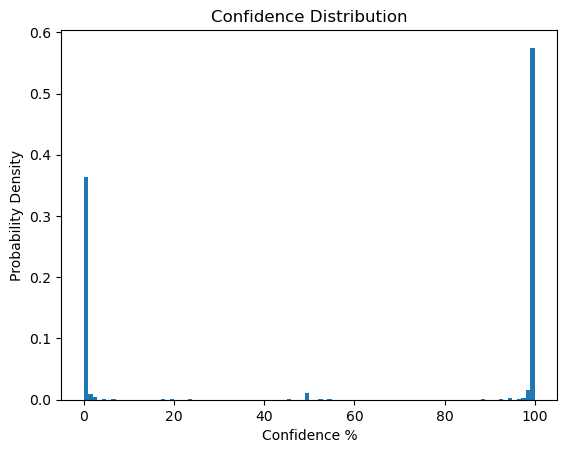

In [51]:
plt.hist(np.round(confs * 100, decimals=2), bins=100, density=True)
plt.title("Confidence Distribution")
plt.xlabel("Confidence %")
plt.ylabel("Probability Density")
plt.savefig("/home/lk3591/Documents/research/logs/2022/figures/confidence_distribution.png", dpi=400)

In [42]:
c[100]

100.0

## Investigating .text section offsets

In [48]:
from itertools import chain
from pathlib import Path
from pprint import pprint
from random import seed, shuffle
import shutil

import numpy as np
import pandas as pd
import pefile
import pickle
from tqdm import tqdm

from classifier import (
    SOREL_TEST_PATH,
    SOREL_TRAIN_PATH,
    WINDOWS_TEST_PATH,
    WINDOWS_TRAIN_PATH,
)

In [9]:
seed(0)
files = list(
    chain(
        SOREL_TEST_PATH.iterdir(),
        SOREL_TRAIN_PATH.iterdir(),
        WINDOWS_TEST_PATH.iterdir(),
        WINDOWS_TRAIN_PATH.iterdir()
    )
)
shuffle(files)

data = [{} for _ in range(len(files))]
for i, f in enumerate(tqdm(files)):
    try:
        pe = pefile.PE(f)
    except pefile.PEFormatError as e:
        continue

    data[i]["size"] = f.stat().st_size
    for section in pe.sections:
        name = section.Name.decode("utf-8", errors="ignore")
        lower = section.PointerToRawData
        upper = lower + section.SizeOfRawData
        data[i][f"l-{name}"] = lower
        data[i][f"u-{name}"] = upper

100%|██████████| 7071/7071 [19:03<00:00,  6.18it/s]  


In [20]:
with open("data", "wb") as handle:
    pickle.dump(data, handle)

In [23]:
data = [{"".join(e for e in k if e.isalnum() or e in {".", "-"}) : v for k, v in d.items()} for d in data]
set(k for k in chain.from_iterable(d.keys() for d in data))

{'l-',
 'l--2',
 'l-.',
 'l-..l',
 'l-.00cfg',
 'l-.0973155',
 'l-.0dk3mna',
 'l-.1m0shgj',
 'l-.41U9az',
 'l-.4h',
 'l-.4rdata',
 'l-.5',
 'l-.666',
 'l-.7add',
 'l-.81tubd',
 'l-.8NzKTbM',
 'l-.916435',
 'l-.9adne',
 'l-.AESeal',
 'l-.ASPack',
 'l-.BSS',
 'l-.CRT',
 'l-.D',
 'l-.DATA',
 'l-.EXP',
 'l-.L',
 'l-.MPRESS1',
 'l-.MPRESS2',
 'l-.NewSec',
 'l-.PEDATA',
 'l-.PNxh7',
 'l-.PTData',
 'l-.SEFCMD',
 'l-.SF',
 'l-.SFH',
 'l-.SFP',
 'l-.STL',
 'l-.Td9C',
 'l-.UPX',
 'l-.UPX1',
 'l-.Upack',
 'l-.YOSWO',
 'l-.aajaic',
 'l-.abb',
 'l-.abb1',
 'l-.aciof',
 'l-.adaia',
 'l-.adata',
 'l-.adate',
 'l-.ah2cIT',
 'l-.ajelhf',
 'l-.alc',
 'l-.ally',
 'l-.aml',
 'l-.aspack',
 'l-.bak',
 'l-.bea',
 'l-.bea1',
 'l-.brdata',
 'l-.bss',
 'l-.c2r',
 'l-.carry',
 'l-.cdata',
 'l-.code',
 'l-.crthunk',
 'l-.d',
 'l-.d046',
 'l-.dHGmL',
 'l-.data',
 'l-.data1',
 'l-.data2',
 'l-.datadA',
 'l-.debug',
 'l-.detourc',
 'l-.detourd',
 'l-.didat',
 'l-.didata',
 'l-.dlop',
 'l-.drdata',
 'l-.dsdir',
 'l-.

In [24]:
df = pd.DataFrame.from_records(data, index=files)
df.to_csv("exceeds_executables/bounds.csv")
df

,size,l-.text,u-.text,l-.rdata,u-.rdata,l-.data,u-.data,l-.pdata,u-.pdata,l-.idata,...,l-.init1,u-.init1,l-.init2,u-.init2,l-.init3,u-.init3,l-e5A,u-e5A,l-.PEDATA,u-.PEDATA
/home/lk3591/Documents/datasets/Windows/processed/train/e1bde0370f04014a6aadc34f413cb24acbf4141a2e33923d76b8ed6a.exe,6449152,1024.0,2668032.0,2668032.0,5810688.0,5810688.0,6215168.0,6215168.0,6329856.0,6329856.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/home/lk3591/Documents/datasets/Windows/processed/train/49b706d5a04c4e90d5655f912143d38d2840640052fcc9d9377d6edd.exe,84376,512.0,71168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/home/lk3591/Documents/datasets/Windows/processed/train/9716cbaf3aa8bde8cde8cc7559c77eebbde29a9433f5b9bbbf7bd3fb.exe,5512104,1024.0,58880.0,NaN,NaN,58880.0,62976.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/home/lk3591/Documents/datasets/Windows/processed/train/2eabdb5b1ab859b1437acb75f8d36593b8cf1c26f8a412b01a9f247e.exe,622560,1024.0,303104.0,303104.0,431104.0,431104.0,434176.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/home/lk3591/Documents/datasets/Sorel/processed/train/00277bf973ca2577fda6e79e4477afbaa1a43500a24add2e6c2b4f25b51abdb5,938085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/home/lk3591/Documents/datasets/Sorel/processed/test/0032bedc45122dd8ea48fc1972e17d16addc8612608240652dc0ef5ce624e6e9,1754520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/home/lk3591/Documents/datasets/Sorel/processed/train/001f2ef56df37224289da2e3565db7841fbd326f9af4b63d1f6f6cbf464fdc8a,771072,1536.0,201728.0,NaN,NaN,730112.0,732672.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/home/lk3591/Documents/datasets/Windows/processed/train/02fd0d6489b987666f6f944f460a553e3eace0db65a6c73b964e1c0e.exe,622560,1024.0,303104.0,303104.0,431104.0,431104.0,434176.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/home/lk3591/Documents/datasets/Sorel/processed/train/0012f743e905ebc437289a1dbcddafe4e261191ad3315152a1de6d9fd7933e03,2312211,1024.0,137728.0,137728.0,163328.0,163328.0,693760.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
exceeds = [""] * len(df.index)
for i, (c, r) in enumerate(df.iterrows()):
    for c in df.columns:
        if r[c] > r["size"]:
            exceeds[i] = exceeds[i] + "_" + str(c) if exceeds[i] != "" else str(c)

In [26]:
df_exceeds = df.copy()
df_exceeds["exceeds"] = exceeds
df_exceeds = df_exceeds[df_exceeds["exceeds"] != ""].dropna(axis=1, how="all")
df_exceeds.to_csv("exceeds_executables/exceeding_bounds.csv")
df_exceeds

,size,l-.text,u-.text,l-.rdata,u-.rdata,l-.data,u-.data,l-.pdata,u-.pdata,l-.idata,...,u-.dtd,l-.dtc,u-.dtc,l-.ph,u-.ph,l-oc,u-oc,l-RT,u-RT,exceeds
/home/lk3591/Documents/datasets/Sorel/processed/test/00236900061dc5ad3a8803f6d910ed51f351f31636a06ecfa46fd71fb6624d5a,217080,1024.0,143360.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,u-.reloc
/home/lk3591/Documents/datasets/Sorel/processed/train/002ab4ddb1f45b69e3fe13946a921ece20df3458223287f71d4781848a5f1c5b,267204,4096.0,221184.0,221184.0,249856.0,249856.0,278528.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,u-.data
/home/lk3591/Documents/datasets/Sorel/processed/train/0010059d2feeb5e6c8bad26756c951f43b6fd547c0b823873155c883c483ef2e,39226,1024.0,25600.0,25600.0,31232.0,31232.0,31744.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,u-.rsrc
/home/lk3591/Documents/datasets/Sorel/processed/train/0020387a18b746f3d501b999666573897f2836e629c40ce23f5bdc6c5e738c26,73728,1024.0,14848.0,NaN,NaN,14848.0,57856.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,u-.brdata_l-.tc_u-.tc_l-tkjdelw_u-tkjdelw_l-ca...
/home/lk3591/Documents/datasets/Sorel/processed/train/000340506b03925a48b32211d9b0eafbc3c15f39ab2f9f0c668c9e45dad365ea,2696189,NaN,NaN,2140672.0,2141184.0,NaN,NaN,NaN,NaN,2127872.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,u-.rsrc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/home/lk3591/Documents/datasets/Sorel/processed/test/00188ae9976d391927c7c7fff94f90a47aea33446c08a8c86348b16abc5136b9,243444,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,l-.rsrc_u-.rsrc_l-.reloc_u-.reloc_u-.vmp1
/home/lk3591/Documents/datasets/Sorel/processed/test/002b07391eca5f48e2cfbb5ce23497169d4bc026ff8a771d07e4d30ba9c6ab1f,24237,1024.0,69632.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,u-.text_l-.rsrc_u-.rsrc_l-.reloc_u-.reloc_l-.s...
/home/lk3591/Documents/datasets/Sorel/processed/test/0027364c581abed56bc2c006e0bd45eeb7ce3e39233ed5e53c7f4760e2c832b4,257288,4096.0,221184.0,221184.0,249856.0,249856.0,278528.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,u-.data
/home/lk3591/Documents/datasets/Sorel/processed/train/002682cb534da543a47fe0b4726af3043d19d5b205757e55ee55980681d19a82,2699318,NaN,NaN,2140672.0,2141184.0,NaN,NaN,NaN,NaN,2127872.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,u-.rsrc


In [28]:
df_hex = df.copy()
df_exceeds_hex = df_exceeds.copy()
for d, p in [(df_hex, "bounds_hex.csv"), (df_exceeds_hex, "exceeding_bounds_hex.csv")]:
    for c in d.columns:
        if c != "exceeds":
            d[c] = d[c].apply(lambda x: hex(int(x)) if not np.isnan(x) else str(x))
    d.to_csv(Path("exceeds_executables") / p)

In [28]:
df = pd.read_csv("exceeds_executables/bounds.csv", index_col=0)
df_hex = pd.read_csv("exceeds_executables/bounds_hex.csv", index_col=0)
df_exceeds = pd.read_csv("exceeds_executables/exceeding_bounds.csv", index_col=0)
df_exceeds = pd.read_csv("exceeds_executables/exceeding_bounds_hex.csv", index_col=0)

In [105]:
Path("exceeds_executables/exceeding_bounds/").mkdir()
for p in df_exceeds.index:
    p = Path(p)
    shutil.copy(p, Path("exceeds_executables/exceeding_bounds/") / p.name)

In [29]:
structured_data = [None for _ in range(len(data))]
for i, d in enumerate(data):
    d_ = {k.replace("l-", "").replace("u-", "") : [None, None] for k in d}
    d_["size"] = d["size"]
    for k, v in d.items():
        if k[0:2] == "l-":
            d_[k.replace("l-", "")][0] = v
        elif k[0:2] == "u-":
            d_[k.replace("u-", "")][1] = v
    structured_data[i] = d_

In [30]:
structured_data[0]

{'size': 6449152,
 '.text': [1024, 2668032],
 '.rdata': [2668032, 5810688],
 '.data': [5810688, 6215168],
 '.pdata': [6215168, 6329856],
 '.idata': [6329856, 6361088],
 '.00cfg': [6361088, 6361600],
 '.rsrc': [6361600, 6365696],
 '.reloc': [6365696, 6449152]}

In [31]:
overlapping = []
for i, d in enumerate(structured_data):
    bounds = list(sorted((v for v in d.values() if isinstance(v, list)), key=lambda x: x[0]))
    if not bounds:  # No sections in this file
        continue
    l_, u_ = None, None
    for l, u in bounds:
        if (l_ and u_) and (l < u_):  # If upper bound of previous section is greater than lower bound of next section
            overlapping.append(files[i])
        l_, u_ = l, u

In [32]:
for p in overlapping:
    shutil.copy(p, "exceeds_executables/overlapping")

In [52]:
i_overlapping = [files.index(f) for f in overlapping]
overlapping_data = [(files[i].as_posix(), {k : hex(v) if isinstance(v, int) else (hex(v[0]), hex(v[1])) for k, v in e.items()}) for i, e in enumerate(structured_data) if i in i_overlapping]
overlapping_data.sort(key=lambda x: x[0])
len(overlapping_data), list(enumerate(overlapping_data))

(7,
 [(0,
   ('/home/lk3591/Documents/datasets/Sorel/processed/test/00054670968af72ece9435244f8682bc2631efeaaff04a615f1ca858906654c4',
    {'size': '0x26071a', 'PSի': ('0x10', '0x200'), '': ('0x10', '0x200')})),
  (1,
   ('/home/lk3591/Documents/datasets/Sorel/processed/test/0010fd458390ba3dbe04c7b46d44086faa664ec1e890166d38507e60f5ca22e4',
    {'size': '0x176016',
     '.text': ('0x147200', '0x175e00'),
     '.data': ('0xba000', '0x117200'),
     '.tls': ('0x117200', '0x117400'),
     '.rdata': ('0x117400', '0x117600'),
     '.idata': ('0x117600', '0x118800'),
     '.edata': ('0x118800', '0x121200'),
     '.rsrc': ('0x121200', '0x141400'),
     '.reloc': ('0x141400', '0x141400'),
     '.ezbexe': ('0x141400', '0x147200'),
     '.adata': ('0x147200', '0x147200')})),
  (2,
   ('/home/lk3591/Documents/datasets/Sorel/processed/test/00221bc72e32ac5516810b460cfcaea5c75758163f560925853d823d9d8719ff',
    {'size': '0x77000',
     '.text': ('0x400', '0x5a00'),
     '.rdata': ('0x5a00', '0x6c00'

In [53]:
for i, d in enumerate(overlapping_data):
    pe = pefile.PE(d[0])
    print(i, d[0])
    pprint(pe.get_warnings())
    print("-" * 88)

0 /home/lk3591/Documents/datasets/Sorel/processed/test/00054670968af72ece9435244f8682bc2631efeaaff04a615f1ca858906654c4
['Error parsing section 0. PointerToRawData should normally be a multiple of '
 'FileAlignment, this might imply the file is trying to confuse tools which '
 'parse this incorrectly.',
 'Suspicious flags set for section 0. Both IMAGE_SCN_MEM_WRITE and '
 'IMAGE_SCN_MEM_EXECUTE are set. This might indicate a packed executable.',
 'Suspicious flags set for section 1. Both IMAGE_SCN_MEM_WRITE and '
 'IMAGE_SCN_MEM_EXECUTE are set. This might indicate a packed executable.',
 'Error parsing section 2. PointerToRawData should normally be a multiple of '
 'FileAlignment, this might imply the file is trying to confuse tools which '
 'parse this incorrectly.',
 'Suspicious flags set for section 2. Both IMAGE_SCN_MEM_WRITE and '
 'IMAGE_SCN_MEM_EXECUTE are set. This might indicate a packed executable.',
 'Corrupt header "IMAGE_IMPORT_DESCRIPTOR" at file offset 494. Exception: '

In [51]:
pe = pefile.PE(overlapping_data[3][0])
print(pe.dump_info())

----------DOS_HEADER----------

[IMAGE_DOS_HEADER]
0x0        0x0   e_magic:                       0x5A4D    
0x2        0x2   e_cblp:                        0x50      
0x4        0x4   e_cp:                          0x2       
0x6        0x6   e_crlc:                        0x0       
0x8        0x8   e_cparhdr:                     0x4       
0xA        0xA   e_minalloc:                    0xF       
0xC        0xC   e_maxalloc:                    0xFFFF    
0xE        0xE   e_ss:                          0x0       
0x10       0x10  e_sp:                          0xB8      
0x12       0x12  e_csum:                        0x0       
0x14       0x14  e_ip:                          0x0       
0x16       0x16  e_cs:                          0x0       
0x18       0x18  e_lfarlc:                      0x40      
0x1A       0x1A  e_ovno:                        0x1A      
0x1C       0x1C  e_res:                         
0x24       0x24  e_oemid:                       0x0       
0x26       0x26

# Use start of code instead of searching for .text

In [56]:
pe = pefile.PE(overlapping_data[3][0])
oh = pe.OPTIONAL_HEADER
l, u = oh.BaseOfCode, oh.BaseOfCode + oh.SizeOfCode
hex(l), hex(u)

('0x1000', '0xdea00')

In [81]:
from collections import OrderedDict
import random

from executable_helper import get_section_bounds_pefile

import importlib
#importlib.reload(get_section_bounds_pefile)

for i, f in enumerate(reversed(files)):
    pe = pefile.PE(f)

    bounds = get_section_bounds_pefile(pe)
    for k in bounds:
        if ".text" in k:
            key = k
            break
    else:
        continue

    pointer_to_raw_data = bounds[key][0]
    size_of_raw_data = bounds[key][1] - bounds[key][0]
    top_1 = bounds[key][1]

    base_of_code = pe.OPTIONAL_HEADER.BaseOfCode
    size_of_code = pe.OPTIONAL_HEADER.SizeOfCode
    top_2 = pe.OPTIONAL_HEADER.BaseOfCode + pe.OPTIONAL_HEADER.SizeOfCode

    if (pointer_to_raw_data != base_of_code) or (size_of_raw_data != size_of_code):
        print(i, f)
        if pointer_to_raw_data != base_of_code:
            print(f"pointer_to_raw_data={hex(pointer_to_raw_data)}, base_of_code={hex(base_of_code)}")
        if size_of_raw_data != size_of_code:
            print(f"size_of_raw_data={hex(size_of_raw_data)}, size_of_code={hex(size_of_code)}")
        print(f"top_1={hex(top_1)}, top_2={hex(top_2)}")
        pprint(OrderedDict((k, (hex(v[0]), hex(v[1]))) for k, v in bounds.items()))
        print("-" * 88)

0 /home/lk3591/Documents/datasets/Windows/processed/train/31f04b6249b9e12e93fb470a8fe25ab879aad414659bc6b965d1ee58.exe
pointer_to_raw_data=0x400, base_of_code=0x1000
top_1=0x2200, top_2=0x2e00
OrderedDict([('.bss\x00\x00\x00\x00', ('0x0', '0x0')),
             ('.text\x00\x00\x00', ('0x400', '0x2200')),
             ('.data\x00\x00\x00', ('0x2200', '0x2400')),
             ('.rdata\x00\x00', ('0x2400', '0x2a00')),
             ('.pdata\x00\x00', ('0x2a00', '0x2e00')),
             ('.xdata\x00\x00', ('0x2e00', '0x3000')),
             ('.idata\x00\x00', ('0x3000', '0x3800')),
             ('.CRT\x00\x00\x00\x00', ('0x3800', '0x3a00')),
             ('.tls\x00\x00\x00\x00', ('0x3a00', '0x3c00')),
             ('.rsrc\x00\x00\x00', ('0x3c00', '0x5000'))])
----------------------------------------------------------------------------------------
1 /home/lk3591/Documents/datasets/Sorel/processed/train/0012f743e905ebc437289a1dbcddafe4e261191ad3315152a1de6d9fd7933e03
pointer_to_raw_data=0x400,

KeyboardInterrupt: 

# Disassemble with Capstone

In [35]:
from collections import defaultdict
from pathlib import Path
import typing as tp

import capstone as cs


arch_modes: tp.ClassVar[tp.Dict[int, tp.List[int]]] = {
    cs.CS_ARCH_X86: (cs.CS_MODE_32, cs.CS_MODE_64, cs.CS_MODE_16),
    cs.CS_ARCH_ARM: (cs.CS_MODE_ARM, cs.CS_MODE_THUMB),
    cs.CS_ARCH_ARM64: (cs.CS_MODE_ARM,),
    cs.CS_ARCH_MIPS: (cs.CS_MODE_MIPS32, cs.CS_MODE_MIPS64),
    cs.CS_ARCH_PPC: (cs.CS_MODE_32, cs.CS_MODE_64),
}


def get_arch_modes(cls, bytes_: str) -> tp.Dict[int, tp.List[int]]:
    successful = defaultdict(list)
    for arch, modes in arch_modes.items():
        for m in modes:
            md = cs.Cs(arch, m)
            dis = list(md.disasm(bytes_, 0x0))
            if dis:
                successful[arch].append(m)
    return dict(successful)



def get_bytes(file: Path, l: int, u: int) -> str:
    l = None if l == "None" else l
    u = None if u == "None" else u
    n = u - l if u is not None and l is not None else u
    with open(file, "rb") as handle:
        handle.seek(l)
        binary = handle.read(n)
    return binary

In [36]:
file = "/home/lk3591/Documents/datasets/Sorel/processed/test/000fd9c84191f9ef0527e215f1d39d24aac2d407f0df4ec781e290439b1c0188"
l = 1024
u = 193536

In [37]:
binary = get_bytes(file, l, u)
binary[0:128]

b'\x9dF\xc7w\xd6\x14\xc7w\xfe@\xc7w\xadF\xc7w\x8dF\xc7w\xefH\xc7w\x07I\xc7w\x00\x00\x00\x00A\x15\xc2u\x00\x00\x00\x00h\r\x08o\xd5\xa2\x08om\xfe\x06o\x00\x00\x00\x00\xaan\xb6w@f\xb6wy\xcf\xb6w\xfc\xab\xb6w\x7fo\xb6w<j\xb6w\x06i\xb6w\x14_\xb6w\xa5\xc2\xb8whu\xb6w\x17y\xb6w\xa2\xbc\xb6w\xdf]\xb6w\x18\x92\xb6w\x04\xc2\xb6w\xba\xc1\xb8w\x00\x00\x00\x00\xe2(\xf1\x08'

In [38]:
" ".join(map(hex, list(binary)[0:128]))

'0x9d 0x46 0xc7 0x77 0xd6 0x14 0xc7 0x77 0xfe 0x40 0xc7 0x77 0xad 0x46 0xc7 0x77 0x8d 0x46 0xc7 0x77 0xef 0x48 0xc7 0x77 0x7 0x49 0xc7 0x77 0x0 0x0 0x0 0x0 0x41 0x15 0xc2 0x75 0x0 0x0 0x0 0x0 0x68 0xd 0x8 0x6f 0xd5 0xa2 0x8 0x6f 0x6d 0xfe 0x6 0x6f 0x0 0x0 0x0 0x0 0xaa 0x6e 0xb6 0x77 0x40 0x66 0xb6 0x77 0x79 0xcf 0xb6 0x77 0xfc 0xab 0xb6 0x77 0x7f 0x6f 0xb6 0x77 0x3c 0x6a 0xb6 0x77 0x6 0x69 0xb6 0x77 0x14 0x5f 0xb6 0x77 0xa5 0xc2 0xb8 0x77 0x68 0x75 0xb6 0x77 0x17 0x79 0xb6 0x77 0xa2 0xbc 0xb6 0x77 0xdf 0x5d 0xb6 0x77 0x18 0x92 0xb6 0x77 0x4 0xc2 0xb6 0x77 0xba 0xc1 0xb8 0x77 0x0 0x0 0x0 0x0 0xe2 0x28 0xf1 0x8'

In [39]:
binary.hex(" ", 2)[0:128]

'9d46 c777 d614 c777 fe40 c777 ad46 c777 8d46 c777 ef48 c777 0749 c777 0000 0000 4115 c275 0000 0000 680d 086f d5a2 086f 6dfe 066'

In [40]:
bytes.fromhex(binary.hex(" ", 2))[0:128]

b'\x9dF\xc7w\xd6\x14\xc7w\xfe@\xc7w\xadF\xc7w\x8dF\xc7w\xefH\xc7w\x07I\xc7w\x00\x00\x00\x00A\x15\xc2u\x00\x00\x00\x00h\r\x08o\xd5\xa2\x08om\xfe\x06o\x00\x00\x00\x00\xaan\xb6w@f\xb6wy\xcf\xb6w\xfc\xab\xb6w\x7fo\xb6w<j\xb6w\x06i\xb6w\x14_\xb6w\xa5\xc2\xb8whu\xb6w\x17y\xb6w\xa2\xbc\xb6w\xdf]\xb6w\x18\x92\xb6w\x04\xc2\xb6w\xba\xc1\xb8w\x00\x00\x00\x00\xe2(\xf1\x08'

In [41]:
b"\x08".decode(), b"8".decode(), b"\x08".hex(), b"8".hex()

('\x08', '8', '08', '38')

In [42]:
b"F".decode(), b"F".hex()

('F', '46')

In [71]:
binary[26:27]

b'\xc7'

In [92]:
md = cs.Cs(cs.CS_ARCH_X86, cs.CS_MODE_32)
md.skipdata = True
dis1 = md.disasm_lite(binary, 0x0)
dis1 = list(dis1)
dis1

[(0, 1, 'popfq', ''),
 (1, 1, '.byte', '0x46'),
 (2, 1, '.byte', '0xc7'),
 (3, 2, 'ja', '0xffffffffffffffdb'),
 (5, 2, 'adc', 'al, 0xc7'),
 (7, 2, 'ja', '7'),
 (9, 1, '.byte', '0x40'),
 (10, 1, '.byte', '0xc7'),
 (11, 2, 'ja', '0xffffffffffffffba'),
 (13, 1, '.byte', '0x46'),
 (14, 1, '.byte', '0xc7'),
 (15, 2, 'ja', '0xffffffffffffff9e'),
 (17, 1, '.byte', '0x46'),
 (18, 1, '.byte', '0xc7'),
 (19, 2, 'ja', '4'),
 (21, 1, '.byte', '0x48'),
 (22, 1, '.byte', '0xc7'),
 (23, 2, 'ja', '0x20'),
 (25, 1, '.byte', '0x49'),
 (26, 1, '.byte', '0xc7'),
 (27, 2, 'ja', '0x1d'),
 (29, 2, 'add', 'byte ptr [rax], al'),
 (31, 3, 'add', 'byte ptr [rcx + 0x15], al'),
 (34, 3, 'ret', '0x75'),
 (37, 2, 'add', 'byte ptr [rax], al'),
 (39, 3, 'add', 'byte ptr [rax + 0xd], ch'),
 (42, 3, 'or', 'byte ptr [rdi - 0x2b], ch'),
 (45, 9, 'movabs', 'byte ptr [0x6f06fe6d6f08], al'),
 (54, 2, 'add', 'byte ptr [rax], al'),
 (56, 1, 'stosb', 'byte ptr [rdi], al'),
 (57, 1, 'outsb', 'dx, byte ptr [rsi]'),
 (58, 2, 'mov'

In [90]:
md = cs.Cs(cs.CS_ARCH_X86, cs.CS_MODE_32)
md.skipdata = True
md.detail = True
data = b"\x12\x02\x88\x3C\xDF\xA1\x29\xC7\x74\x08\xDF\xE3"
dataLength = 0x0
key_mnemonic = ".byte"
disassembly = list(md.disasm(data, dataLength))
skipped = [d.mnemonic == key_mnemonic for d in disassembly]
skipped, disassembly

([False, False, False, True, True],
 [<CsInsn 0x0 [1202]: adc al, byte ptr [edx]>,
  <CsInsn 0x2 [883cdf]: mov byte ptr [edi + ebx*8], bh>,
  <CsInsn 0x5 [a129c77408]: mov eax, dword ptr [0x874c729]>,
  <CsInsn 0xa [df]: .byte 0xdf>,
  <CsInsn 0xb [e3]: .byte 0xe3>])

In [74]:
md.__dict__

{'arch': 3,
 '_mode': 4,
 'csh': c_ulong(94474947442176),
 '_syntax': 1,
 '_detail': False,
 '_imm_unsigned': False,
 '_diet': False,
 '_x86reduce': False,
 '_skipdata_mnem': '.byte',
 '_skipdata_cb': (None, None),
 '_skipdata_opt': <capstone._cs_opt_skipdata at 0x7ff275e8a040>,
 '_skipdata': False}

In [77]:
md.detail

KeyboardInterrupt: 

In [56]:
dis2 = md.disasm(binary[64:256], 0x0)
dis2 = list(dis2)
dis2

[<CsInsn 0x0 [79cf]: jns 0xffffffd1>,
 <CsInsn 0x2 [b677]: mov dh, 0x77>,
 <CsInsn 0x4 [fc]: cld >,
 <CsInsn 0x5 [ab]: stosd dword ptr es:[edi], eax>,
 <CsInsn 0x6 [b677]: mov dh, 0x77>,
 <CsInsn 0x8 [7f6f]: jg 0x79>,
 <CsInsn 0xa [b677]: mov dh, 0x77>,
 <CsInsn 0xc [3c6a]: cmp al, 0x6a>,
 <CsInsn 0xe [b677]: mov dh, 0x77>,
 <CsInsn 0x10 [06]: push es>,
 <CsInsn 0x11 [69b677145fb677a5c2b8]: imul esi, dword ptr [esi - 0x49a0eb89], 0xb8c2a577>,
 <CsInsn 0x1b [7768]: ja 0x85>,
 <CsInsn 0x1d [75b6]: jne 0xffffffd5>,
 <CsInsn 0x1f [7717]: ja 0x38>,
 <CsInsn 0x21 [79b6]: jns 0xffffffd9>,
 <CsInsn 0x23 [77a2]: ja 0xffffffc7>,
 <CsInsn 0x25 [bcb677df5d]: mov esp, 0x5ddf77b6>,
 <CsInsn 0x2a [b677]: mov dh, 0x77>,
 <CsInsn 0x2c [1892b67704c2]: sbb byte ptr [edx - 0x3dfb884a], dl>,
 <CsInsn 0x32 [b677]: mov dh, 0x77>,
 <CsInsn 0x34 [bac1b87700]: mov edx, 0x77b8c1>,
 <CsInsn 0x39 [0000]: add byte ptr [eax], al>,
 <CsInsn 0x3b [00e2]: add dl, ah>,
 <CsInsn 0x3d [28f1]: sub cl, dh>,
 <CsInsn 0x3f [0

In [44]:
b"\x46".hex(), b"\x46".decode()

('46', 'F')

In [45]:
b"F" == b"\x46"

True